In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
from channelparams import *

In [14]:
# discretization
ny = 500; Ly = 160.; dy = Ly/ny
nx = 200; Lx = 6.; dx = Lx/nx

y = np.arange(-Ly/2.+dy/2.,+Ly/2.,dy)[np.newaxis,:]
x = np.arange(-Lx/2.+dx/2.,+Lx/2.,dx)[:,np.newaxis]

κ = fbc['κsill']

print(f"κ = {round(fbc['κsill'], 3)} (non-dimensional), αcode = {round(fbc['κsill']/2., 3)} (non-dimensional), r = {round(fbc['rsill'], 3)}")

B = fbc['ηinf']/fbc['H']
print(f"B = {B}")

αi = -0.5*(1+2./fbc['rsill'])

κ = 3.021 (non-dimensional), αcode = 1.51 (non-dimensional), r = 0.662
B = 2.0


In [15]:
# sill
h0 = np.exp(-(fbc['λ']*y)**2) * fbc['Hsill']/fbc['H']
h = (h0 + 0.5*κ*x**2)

(3.0, -3.0)

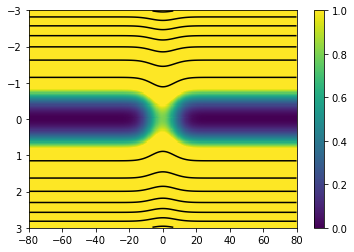

In [16]:
plt.pcolor(y,x,h)
plt.clim([0.,1.])
plt.colorbar()
plt.contour(y.flatten(),x.flatten(),h, colors='k')
plt.ylim([Lx/2.,-Lx/2.])

#### Calculate width of zero-PV solution by solving 8th order polynomial (reduced to quartic)

In [152]:
def calc_width(Q):
    a = (1.+κ)/8.
    b = h0 - B
    e = (72.*Q**2)/(κ*(1.+κ))
    
    p = (-3.*b**2)/(8.*a**2)
    q = b**3/(8.*a**3)

    Δ0 = 12.*a*e
    Δ1 = 27.*b**2*e

    T = ( (Δ1 + np.sqrt(Δ1**2 - 4.*Δ0**3))/2. )**(1./3.)

    S = (1./2.) * np.sqrt(
        -(2./3.)*p + (1./(3.*a))*(T + Δ0/T)
    )
    
    x3 = -b/(4*a) + S + (1./2.)*np.sqrt( -4.*S**2 - 2*p - q/S)
    x4 = -b/(4*a) + S - (1./2.)*np.sqrt( -4.*S**2 - 2*p - q/S)
    
    w3 = np.sqrt(x3)
    w4 = np.sqrt(x4)
    
    w = np.zeros_like(w3)
    w[y<0.] = w3[y<0.]
    w[y>=0.] = w4[y>=0.]

    return w

### Search for critical solution
Here, we loop through This is equivalent to maximizing $Q$, as in Borenas and Lundberg.

Qcrit = 0.538


/var/folders/_7/54nm1vyx6gg9l5f555w0c1tc0000gn/T/ipykernel_68695/203758857.py:15: RuntimeWarning: invalid value encountered in true_divide
  -(2./3.)*p + (1./(3.*a))*(T + Δ0/T)
/var/folders/_7/54nm1vyx6gg9l5f555w0c1tc0000gn/T/ipykernel_68695/203758857.py:12: RuntimeWarning: invalid value encountered in sqrt
  T = ( (Δ1 + np.sqrt(Δ1**2 - 4.*Δ0**3))/2. )**(1./3.)


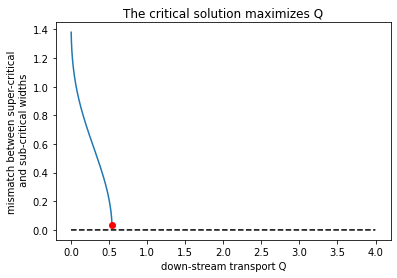

In [153]:
mismatch_vec = []
Q_vec = np.arange(0.,B*2,B/1000.)

Q_crit = np.nan
mismatch_crit = 0.1

for Q in Q_vec:
    w = calc_width(Q)
    mismatch = np.abs(w[0,np.int64(ny/2.)] - w[0,np.int64(ny/2.)-1])
    mismatch_vec.append(mismatch)
    if mismatch < mismatch_crit:
        mismatch_crit = mismatch
        Q_crit = Q
        w_crit = w
    
plt.plot(Q_vec, mismatch_vec)
plt.plot(Q_vec, 0.*Q_vec, 'k--')
plt.plot(Q_crit, mismatch_crit, 'ro')
plt.xlabel("down-stream transport Q")
plt.ylabel("mismatch between super-critical\n and sub-critical widths")
plt.title("The critical solution maximizes Q")

print(f"Qcrit = {Q_crit}")

#### Plotting the solution

In [172]:
x0 = 12.*Q_crit/(κ*(1.+κ)*w_crit**3)
xp = x-x0

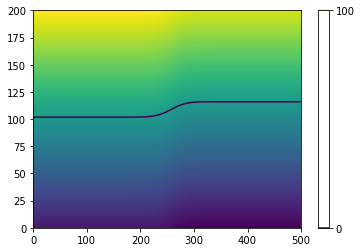

In [173]:
plt.pcolor(xp)
plt.contour(xp, levels=[0.,100])
plt.colorbar()

In [174]:
d = 0.5 * (1.+κ) * ((0.5*w_crit)**2 - xp**2)
d[d<0.] = np.nan

(3.0, -3.0)

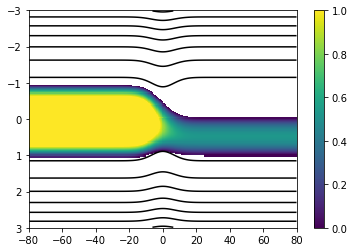

In [175]:
plt.contour(y.flatten(),x.flatten(),h, colors='k')
q = plt.pcolor(y,x,d)
q.set_clim([0,1])
plt.colorbar()
plt.ylim([Lx/2.,-Lx/2.])

(3.0, -3.0)

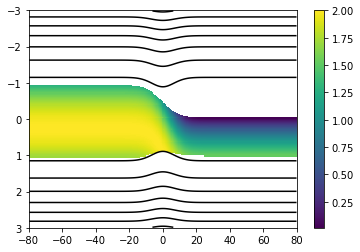

In [176]:
plt.contour(y.flatten(),x.flatten(),h, colors='k')
plt.pcolor(y,x,d+h)
plt.colorbar()
plt.ylim([Lx/2.,-Lx/2.])

(α, β, γ) = (-2.01, 0.931, 0.767)


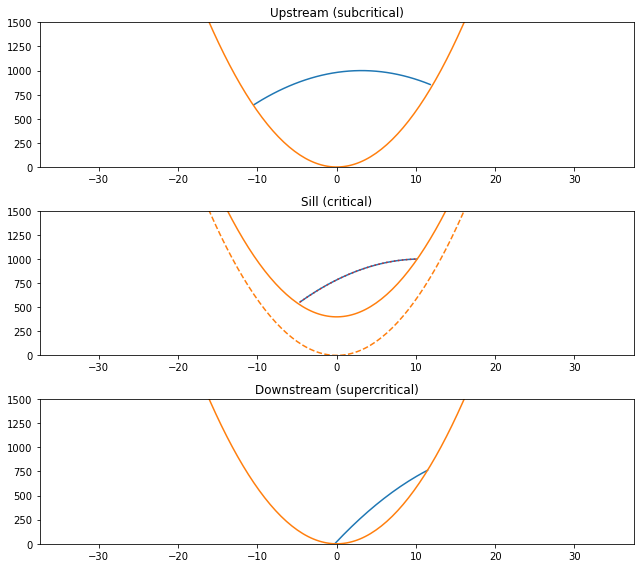

In [209]:
plt.figure(figsize=(9,8))
plt.subplot(3,1,1)
plt.plot(x*Ld/1000., (d+h)[:,0]*H)
plt.plot(x*Ld/1000., h[:,0]*H)
plt.title("Upstream (subcritical)")
plt.ylim([0.,3.0*H])

plt.subplot(3,1,2)
plt.plot(x*Ld/1000., (d+h)[:,np.int64(ny/2.)]*H)
plt.plot(x*Ld/1000., h[:,np.int64(ny/2.)]*H)

j = np.int64(ny/2.)
α = αi
β = -2*α*x0[0, j]
γ = α*(x0[0, j]-w_crit[0, j]/2.)*(x0[0, j]+w_crit[0, j]/2.)

print(f"(α, β, γ) = ({round(α, 3)}, {round(β, 3)}, {round(γ, 3)})")

dr = α*x**2 + β*x + γ
dr[dr<=0.]=np.nan
plt.plot(x*Ld/1000., (dr+h[:, [j]])*H, "C3:")

plt.plot(x*Ld/1000., h[:,0]*H, "C1--")
plt.title("Sill (critical)")
plt.ylim([0.,3.0*H])

plt.subplot(3,1,3)
plt.plot(x*Ld/1000., (d+h)[:,-1]*H)
plt.plot(x*Ld/1000., h[:,-1]*H)
plt.title("Downstream (supercritical)")
plt.ylim([0.,3.0*H])

plt.tight_layout()

In [198]:
(dr+h[:, [j]]).shape

(200, 1)

In [193]:
x.size

200

In [184]:
dr

array([[-1.99245381e+01],
       [-1.95383753e+01],
       [-1.91558309e+01],
       [-1.87769051e+01],
       [-1.84015977e+01],
       [-1.80299088e+01],
       [-1.76618384e+01],
       [-1.72973865e+01],
       [-1.69365530e+01],
       [-1.65793381e+01],
       [-1.62257416e+01],
       [-1.58757636e+01],
       [-1.55294041e+01],
       [-1.51866631e+01],
       [-1.48475405e+01],
       [-1.45120365e+01],
       [-1.41801509e+01],
       [-1.38518838e+01],
       [-1.35272352e+01],
       [-1.32062051e+01],
       [-1.28887935e+01],
       [-1.25750003e+01],
       [-1.22648257e+01],
       [-1.19582695e+01],
       [-1.16553318e+01],
       [-1.13560126e+01],
       [-1.10603118e+01],
       [-1.07682296e+01],
       [-1.04797658e+01],
       [-1.01949206e+01],
       [-9.91369378e+00],
       [-9.63608547e+00],
       [-9.36209565e+00],
       [-9.09172431e+00],
       [-8.82497145e+00],
       [-8.56183708e+00],
       [-8.30232120e+00],
       [-8.04642380e+00],
       [-7.7

In [160]:
np.nanmax(d+h)*H

999.9999999527879

In [138]:
Δz = B

In [139]:
Q_crit

nan

In [140]:
Δz**2/(2+rsill)*np.sqrt(3*rsill/2.)

0.05989748621859372

In [141]:
Δz**2

0.16000000000000003

In [142]:
2*rsill

1.3242674137224373

In [143]:
Q_crit

nan

In [144]:
3*rsill/2

0.9932005602918279

In [90]:
wc

NameError: name 'wc' is not defined

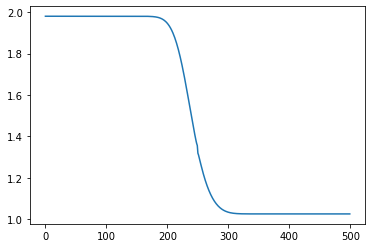

In [164]:
plt.plot(np.transpose(w_crit))